# **AEGIS LENS EXPLORATORY DATA ANALYSIS**

## i. Import Libraries

Pada tahap ini kita akan melakukan import libraries yang di perlukan untuk kebutuhan Exploratory Data Analysis. Library ini akan terus update tergantung apa yang akan kita eksplor dibawah.

In [2]:
#Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import cv2
from collections import defaultdict

## ii. Split Data Train and Val

Pada tahap ini kita akan melakukan split dataset menjadi 2 bagian, yaitu train dan validation. Kita membagi dataset menjadi 80 % untuk data train dan 20 % untuk data validation.

In [3]:
#Split Train dan Val
base_dir = "Dataset"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")

output_dirs = {
    "train": 0.8,
    "val": 0.2,
}

for split in output_dirs:
    os.makedirs(os.path.join(base_dir, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, "labels"), exist_ok=True)

image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)

total = len(image_files)
start = 0
for split, ratio in output_dirs.items():
    count = int(total * ratio)
    selected_files = image_files[start:start + count]
    for file in selected_files:
        src_img = os.path.join(images_dir, file)
        dst_img = os.path.join(base_dir, split, "images", file)
        shutil.copy(src_img, dst_img)

        label_file = file.rsplit('.', 1)[0] + ".txt"
        src_label = os.path.join(labels_dir, label_file)
        dst_label = os.path.join(base_dir, split, "labels", label_file)
        if os.path.exists(src_label):
            shutil.copy(src_label, dst_label)

    start += count

## iii. Loading Data for EDA

Pada tahap ini kita akan loading dataset train yang sudah di split dari dataset utama. Dataset train inilah yang akan kita analisis, dimana diharapkan hasil analisis ini dapat membantu kita dalam pembuatan model.

In [3]:
#Dataset Train path
images_dir = 'Dataset/train/images'
labels_dir = 'Dataset/train/labels'

In [4]:
#Melihat Semua Label/Class
classes_path = 'Dataset/classes.txt'

with open(classes_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print("Class Names:")
for idx, class_name in enumerate(classes):
    print(f"{idx}: {class_name}")

Class Names:
0: Bus
1: Car
2: LicensePlate
3: Motorcycle
4: Truck


Insight : 

Terdapat 5 Class/Label, yaitu :

0 untuk Bus  
1 untuk Car  
2 untuk LicensePlate  
3 untuk Motorcycle  
4 untuk Truck  

Kelas-kelas tersebut adalah jenis-jenis kendaraaan yang kita klasifikasikan serta 1 plat nomor kendaraan yang akan di deteksi nomornya.

In [5]:
#Loading data train
records = []

image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(label_path):
        continue

    image = plt.imread(image_path)
    h, w = image.shape[:2]

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            records.append({
                'image': image_file,
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height,
                'area': width * height,
                'aspect_ratio': width / height if height != 0 else 0
            })

df = pd.DataFrame(records)

## iv. EDA

Pada bagian ini kita akan melakukan beberapa analisis pada dataset, berikut adalah beberapa pertanyaan yang harus di analisis pada dataset : 

1. Bagaimana distribusi objek di tiap kelas?
2. Bagaimana sebaran jumlah objek yang terdapat pada gambar?
3. Bagaimana pola distribusi ukuran bounding box setiap kelas?
4. Seperti apa distribusi rasio bouding box (lebar dibandingkan tinggi)?
5. Berikan contoh visualiasi gambar yang telah di labeling?
6. Bagaimana gambaran heatmap posisi centroid box?

### 1. Distribusi objek di setiap kelas

C:\Users\maruf\AppData\Local\Temp\ipykernel_3112\1266381708.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='class_id', data=df, palette='Set2')


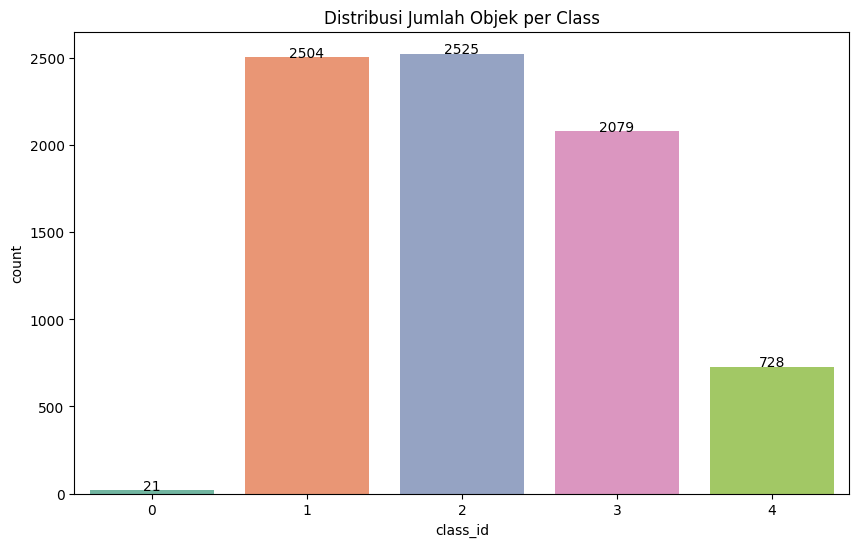

In [6]:
# Plot Distribusi jumlah objek per class
plt.figure(figsize=(10,6))
ax = sns.countplot(x='class_id', data=df, palette='Set2')
plt.title('Distribusi Jumlah Objek per Class')

# Menambahkan angka di atas setiap bar
for p in ax.patches:
    height = p.get_height()  # tinggi bar = jumlah objek
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,  # posisi teks ditengah atas bar
            int(height), 
            ha="center")  # ha = horizontal alignment center

plt.show()

Insight :  

- Diagram bar diatas **menggambarkan distribusi kelas di dataset train** 
- Di **kelas 0 (Bus)** terlihat **datanya sangat sedikit** dibandingkan 4 kelas lainnya. Ini menggambarkan bahwa terlihat **adanya imbalance data.**
- **Kelas 2 (Motorcycle)** mempunyai **data yang paling banyak**, lalu kelas 1 (Car) dan 3 (Motorcycle) berada di urutan kedua dan ketiga, dimana perbedaan jumlah kelas 2 dan 3 kurang lebih 300 data. 
- **Kelas 4 (Truck)** juga mempunyai **data yang terbilang sedikit** walaupun masih jauh lebih banyak dari data kelas 0 (Bus)
- Dari keluruhan bisa disimpulkan bahwa **di tempat pengambilan data masih di dominasi dengan mobil dan motor**.
- Jumlah **LicensePlate** kalau dibandingkan dengan data dari semua kelas maka **termasuk sedikit kendaraan yang bisa di label LicensePlatenya**
- Dari keseluruhan data, **jika ingin mengatasi data unbalance pada kelas 0 (Bus) dan kelas 1 (Truck)** bisa dilakukan **pengambilan sampling lagi**, dimana untuk Bus pengambilan sampling harus dilakukan di sekitar terminal-terminal bus serta untuk pengambilan sampling Truk bisa di lokasi yang di dominasi pabrik-pabrik atau gudang-gudang logistik.

___________________________________________________________________________________________________________________________________________________________________________________________
Berdasarkan insight di atas dimana class 0 (Bus) sangat sedikit, saya akan coba perlihatkan contoh gambar yang ada kelas 0

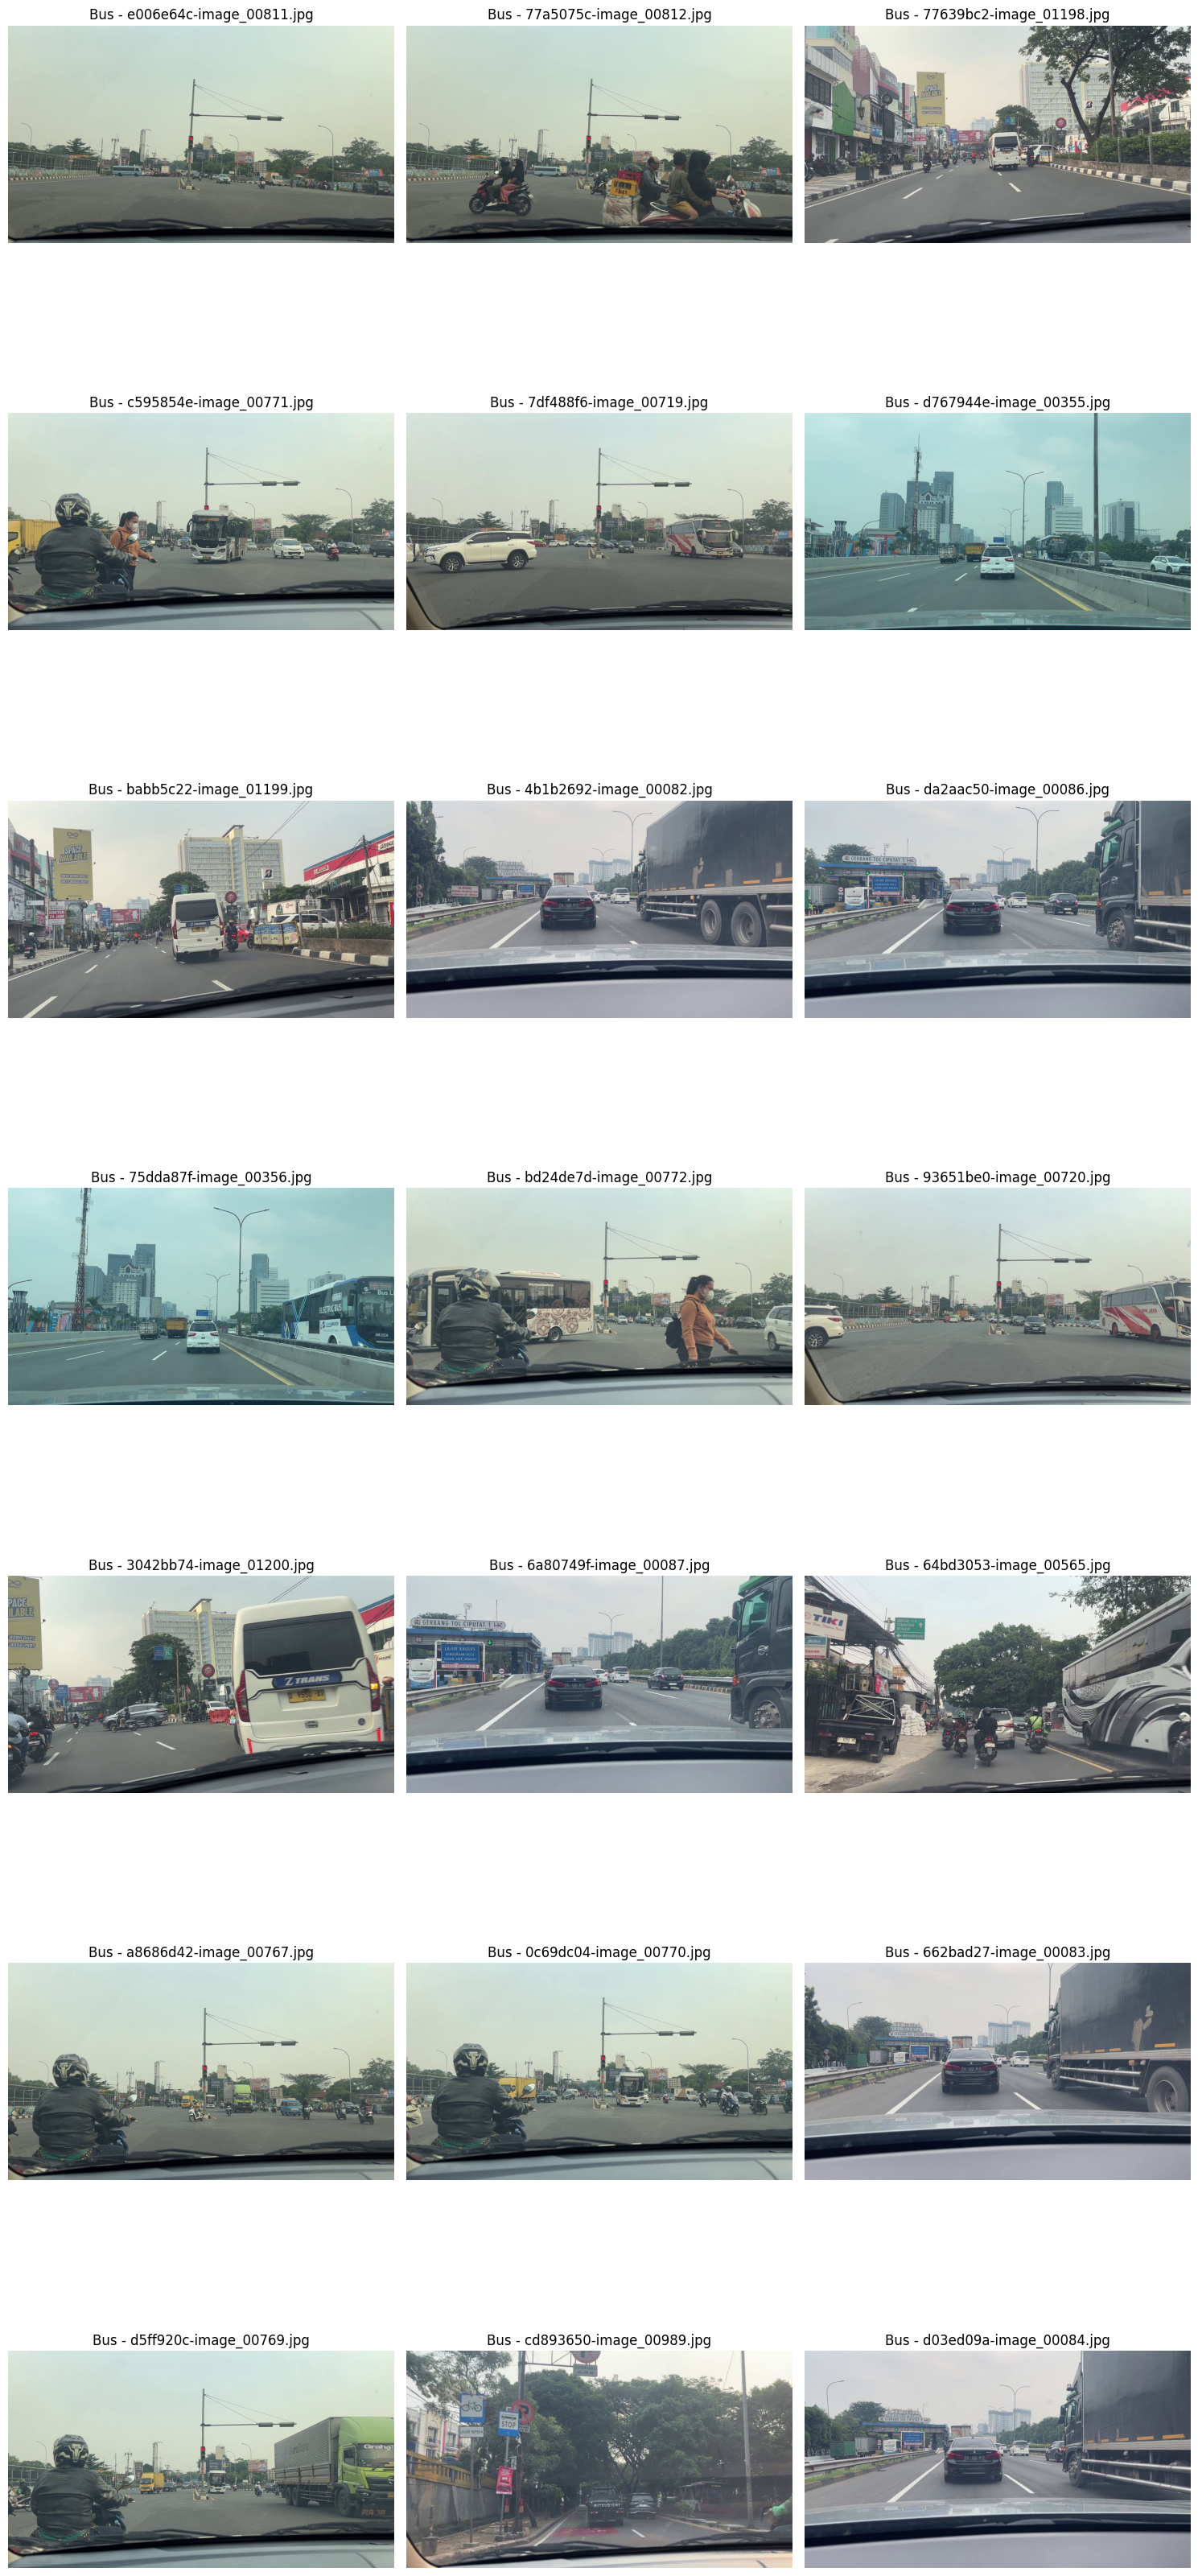

In [16]:
max_images = 30
cols = 3

images_to_show = []

for label_file in os.listdir(labels_dir):
    if not label_file.endswith('.txt'): continue
    label_path = os.path.join(labels_dir, label_file)

    with open(label_path, 'r') as f: lines = f.readlines()
    if not any(line.startswith('0 ') for line in lines): continue

    image_file = label_file.replace('.txt', '.jpg')
    image_path = os.path.join(images_dir, image_file)
    if not os.path.exists(image_path): continue

    images_to_show.append(image_path)

    if len(images_to_show) >= max_images:
        break

# hitung rows sesuai jumlah gambar yang akan ditampilkan
rows = len(images_to_show) // cols + int(len(images_to_show) % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, image_path in enumerate(images_to_show):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Bus - {os.path.basename(image_path)}")
    axes[i].axis('off')

# matikan semua axes yang tidak terpakai
for j in range(len(images_to_show), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### 2. Sebaran jumlah objek yang terdapat pada gambar

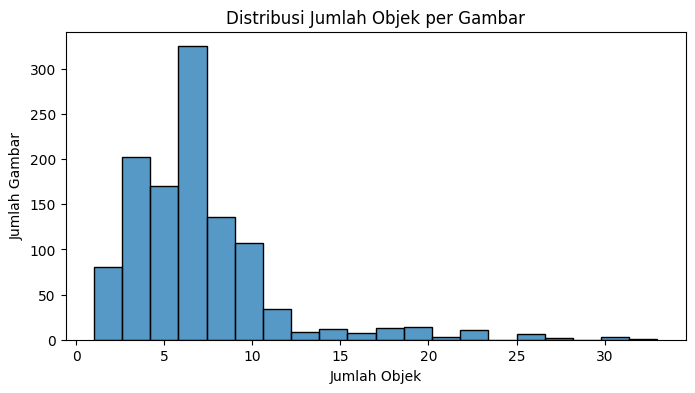

In [8]:
# Distribusi jumlah objek per gambar
obj_per_image = df.groupby('image').size()
plt.figure(figsize=(8,4))
sns.histplot(obj_per_image, bins=20, kde=False)
plt.title('Distribusi Jumlah Objek per Gambar')
plt.xlabel('Jumlah Objek')
plt.ylabel('Jumlah Gambar')
plt.show()

Insight :  

- Diagram diatas menunjukkan **distribusi objek ter-label per gambar**
- Sebagian besar gambar **memiliki objek lebih dari 1** dan **mayoritas gambar terdapat 4 sampai 8 objek** di dalamnya
- Ternyata **ada juga gambar yang memiliki 15 - 20 objek**, bahkan sampai 30 objek per gambarnya, tapi hanya dibawah 10 gambar
- **Distribusi jumlah objek tiap gambar terlihat tidak merata** dimana **didominasi** dengan gambar dengan **jumlah objek sedang (4 -5 objek)**, ini bisa jadi nanti **akan mempengaruhi model**, dimana model akan bagus untuk menangkap objek pada rentang tersebut.

___________________________________________________________________________________________________________________________________________________________________________________________
Setelah melihat distribusi jumlah objek per-gambar, kita akan lihat juga beberapa aspek yang berhubungan, yaitu  
1. Rata-rata objek per gambar  
2. Persentase gambar yang hanya punya 1 objek  
3. Persentase gambar dengan kombinasi kendaraan + license plate

In [ ]:
# Hitung jumlah objek per gambar dan jenis kelas yang muncul
image_obj_count = defaultdict(int)
image_classes = defaultdict(set)

for _, row in df.iterrows():
    img = row['image']
    cls = row['class_id']
    image_obj_count[img] += 1
    image_classes[img].add(cls)

# Rata-rata jumlah objek per gambar
total_objects = sum(image_obj_count.values())
total_images = len(image_obj_count)
avg_objects_per_image = total_objects / total_images

# Persentase gambar dengan hanya 1 objek
single_obj_images = sum(1 for count in image_obj_count.values() if count == 1)
pct_single_obj_images = (single_obj_images / total_images) * 100

# Persentase gambar dengan kombinasi kendaraan + LicensePlate
vehicle_classes = {0, 1, 3, 4}
plate_class = 2

combination_images = 0
for img, classes in image_classes.items():
    has_vehicle = any(c in vehicle_classes for c in classes)
    has_plate = plate_class in classes
    if has_vehicle and has_plate:
        combination_images += 1

pct_combination = (combination_images / total_images) * 100


print(f"Total gambar                      : {total_images}")
print(f"Rata-rata objek per gambar        : {avg_objects_per_image:.2f}")
print(f"Gambar dengan hanya 1 objek       : {single_obj_images} ({pct_single_obj_images:.2f}%)")
print(f"Gambar dengan kendaraan + plate   : {combination_images} ({pct_combination:.2f}%)")


Total gambar                      : 1137
Rata-rata objek per gambar        : 6.91
Gambar dengan hanya 1 objek       : 25 (2.20%)
Gambar dengan kendaraan + plate   : 1005 (88.39%)


Insight :  
1. **Rata rata jumlah objek per gambar** ada di angka **6.91**, ini menunjukkan berarti mayoritas gambar memiliki banyak objek
2. Ada sekitar **2.2 % gambar** yang hanya mengandung **1 objek**, menandakan dataset ini cocok untuk model yang mendeteksi banyak objek  
3. Gambar dengan **kombinasi kendaraan dan LicensePlate** ada sekitar **1005 gambar (88.39%)** dimana ini menunjukkan bahwa LicensePlate muncul bersamaan dengan kendaraannya, jadi kalau ada LicensePlate pasti ada kendaraannya. Ini akan membantu model untuk memahami posisi LicensePlate.

### 3. Pola distribusi ukuran bounding box setiap kelas

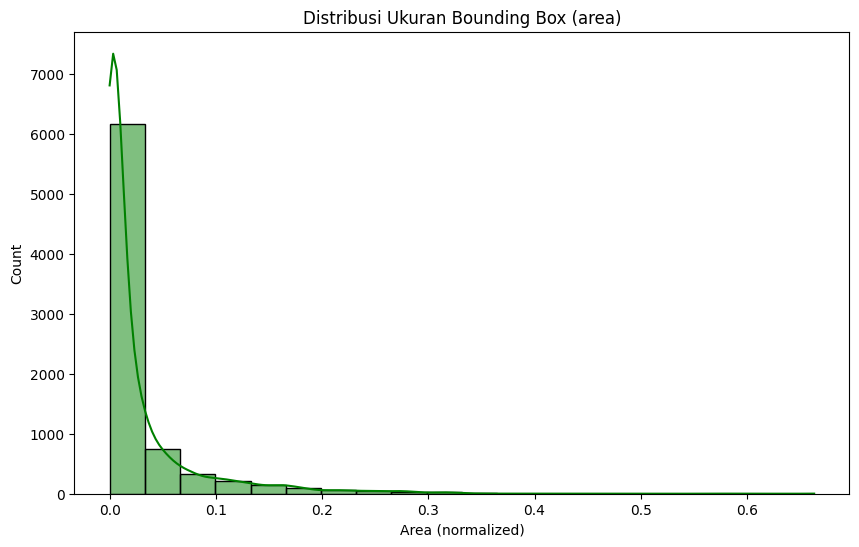

In [19]:
# Distribusi ukuran bounding box (area)
plt.figure(figsize=(10,6))
sns.histplot(df['area'], bins=20, color='green', stat='count', kde=True)
plt.title('Distribusi Ukuran Bounding Box (area)')
plt.xlabel('Area (normalized)')
plt.show()

Insight :  
- Diagram diatas memperlihatkan **distribusi ukuran bounding box pada objek di dataset**
- Terlihat dari diagram bahwa **mayoritas ukuran bounding box kecil**, dimana itu mungkin **didominasi oleh LicensePlate** atau **objek-objek yang jauh dari kamera.**
- **Ukuran bounding box pada LicensePlate yang kecil** akan menjadi **tantangan untuk model OCR nanti**, karena model OCR harus membaca nomor plate dan expired date-nya. 
- Dari diagram juga terlihat bahwa **ada juga bounding box yang besar** dimana itu pasti di dominasi oleh Bus dan Truck atau Mobil yang dekat dengan kamera
- Karena di dominasi oleh bounding box dengan ukuran yang kecil maka **model harus di optimalkan dalam menangkap objek-objek kecil**
- Sebaliknya karena minimnya bounding box dengan ukuran yang besar **model juga harus bisa menangkap objek-objek dengan ukuran besar**

### 4. Distribusi rasio bouding box (lebar dibandingkan tinggi)

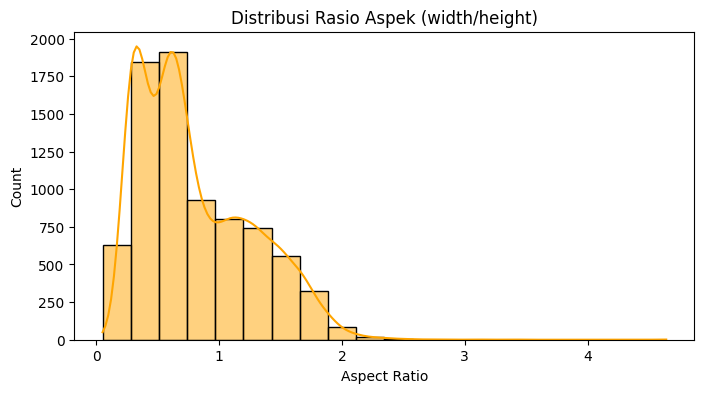

In [22]:
# Distribusi rasio aspek bbox
plt.figure(figsize=(8,4))
sns.histplot(df['aspect_ratio'], bins=20, kde=True, color='orange')
plt.title('Distribusi Rasio Aspek (width/height)')
plt.xlabel('Aspect Ratio')
plt.show()

Insight :
- Diagram di atas menunjukkan **distribusi aspek rasio dari bounding box (tinggi x lebar)**
- **Rasio yang kecil** (kurang dari 1) bisa jadi **mewakili LicensePlate**
- **Rasio yang besar** (lebih dari 1 ) bisa jadi **mewakili kelas Bus, Car, dan Truck serta kelas-kelas yang dekat dengan kamera.**
- **Rasio licenseplate** pastinya **memiliki lebar (x) yang lebih besar di bandingkan tingginya (y)**, serta **Rasio motor** pastinya **memiliki tinggi (y) yang lebih besar daripada lebarnya (x)**.  
- Jadi **license plate** tergolong **shapenya persegi panjang horizontal** sedangan **motor** **shapenya persegi panjang vertical**

### 5. Contoh visualiasi gambar yang telah di labeling

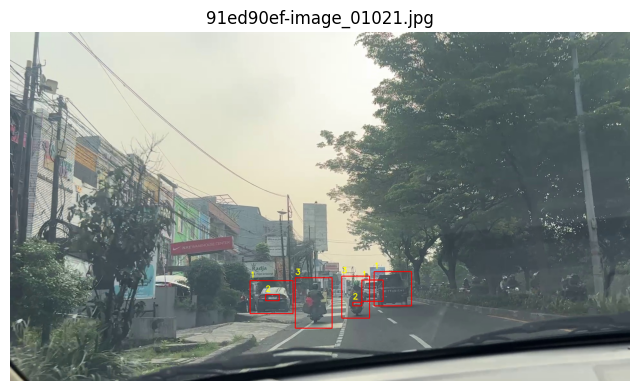

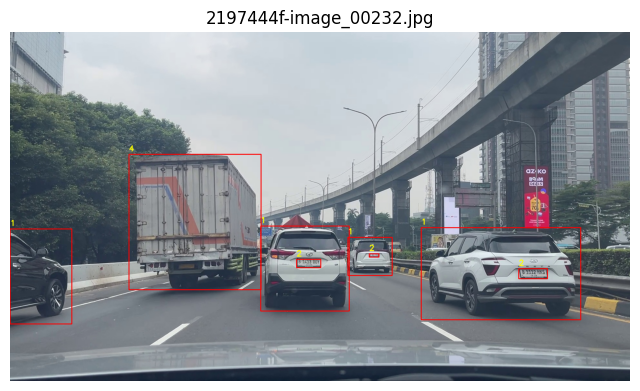

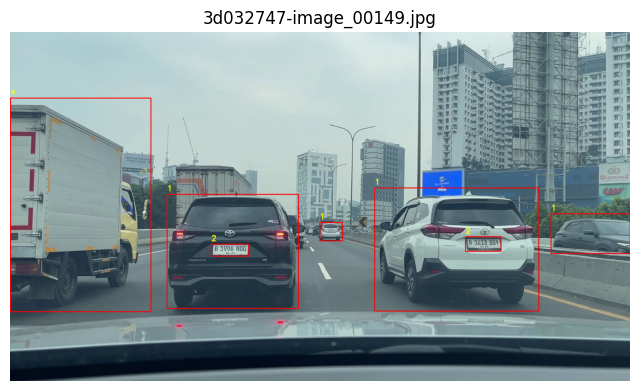

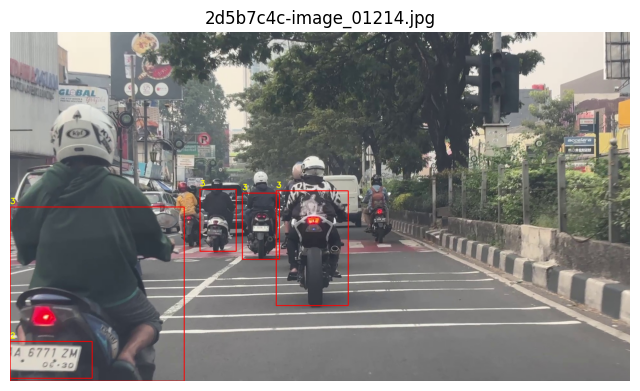

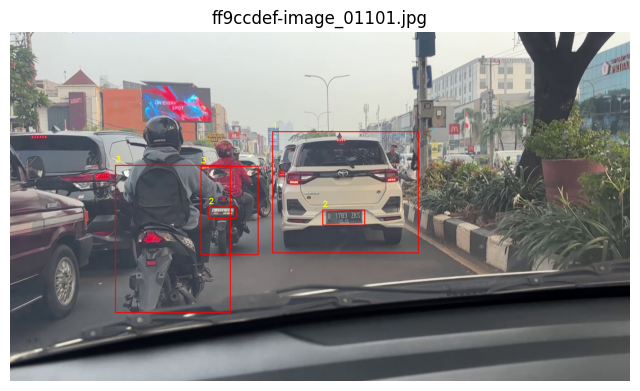

In [ ]:
# Visualisasi 5 gambar random + bounding box
sample_images = df['image'].unique()
sample_images = np.random.choice(sample_images, size=min(5, len(sample_images)), replace=False)

for image_file in sample_images:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    boxes = df[df['image']==image_file]
    for _, row in boxes.iterrows():
        xmin = int((row['x_center'] - row['width']/2) * w)
        ymin = int((row['y_center'] - row['height']/2) * h)
        xmax = int((row['x_center'] + row['width']/2) * w)
        ymax = int((row['y_center'] + row['height']/2) * h)
        class_id = row['class_id']

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
        cv2.putText(image, str(class_id), (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2)

    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(image_file)
    plt.axis('off')
    plt.show()

Insight :  
- Diatas ini adalah **contoh visualiasi gambar yang telah di labeling**
- **Mayoritas objek di ambil dari belakang**, hanya **sedikit objek yang di labeling dari samping atau depan**
- Terlihat **perbedaan ukuran** dari labeling tiap class, contohnya pada **mobil** terlihat **panjang dan lebarnya** lebih **simetris** dibandingkan motor.
- Untuk **motor** **shape labelnya** terlihat **lebih panjang** dibandingkan kelas lain
- Pada kelas **truk** juga terlihat ukuran **shapenya jauh lebih besar** dibandingkan kelas lain
- **LicensePlate** adalah shape yang **paling kecil** dari semua jenis kelas
- Dari **perbedaan shape-shape** tersebut model harusnya **bisa membedakan** tiap-tiap kelas dengan baik

### 6. Persebaran posisi centroid pada bounding box

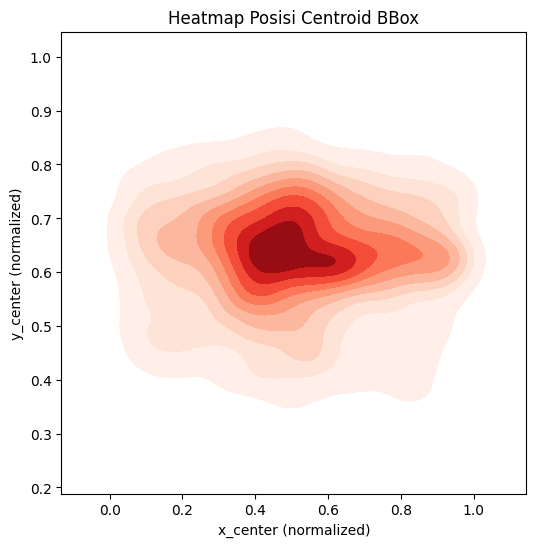

In [ ]:
# Heatmap sebaran posisi centroid bouding box
plt.figure(figsize=(6,6))
sns.kdeplot(x=df['x_center'], y=df['y_center'], fill=True, cmap='Reds')
plt.title('Heatmap Posisi Centroid BBox')
plt.xlabel('x_center (normalized)')
plt.ylabel('y_center (normalized)')
plt.show()

Insight :
- Di atas adalah **heatmap posisi centroid box**
- Dari heatmap di atas bisa disimpulkan **rata-rata object ada di sekitar (0,4 - 0.6 , 0,6 - 0,7)**, ini menandakan objek yang dideteksi kebanyakan ada di posisi tersebut. Itu terlihat dari **warna di sekitar (0,4 - 0.6 , 0,6 - 0,7) yang sangat gelap**
- Terlihat dari diagram **posisi centroid box** rata-rata **terpusat di tengah** gambar, itu menggambarkan bahwa **mayoritas objek ada ditengah gambar**
- Kemungkinan plat nomor berada **di sekitar 0.6**, karena pasti **letaknya di bawah tengah gambar**

## Ringkasan EDA

- Dataset mengandung 5 kelas dimana ada imbalance pada kelas Bus dan Truck
- Mayoritas gambar mengandung lebih dari 1 objek, dengan kombinasi kendaraan dan LicensePlate
- Ukuran dan rasio bounding box bervariasi, mulai dari LicensePlate yang cenderung kecil dan horizontal sampai dengan Motorcycle yang cenderung vertical
- Centroid bounding box berkumpul di tengah area gambar.